In [ ]:

%matplotlib notebook
from importlib import reload
import numpy as np
from tqdm import tnrange
import time
from scipy.stats import multivariate_normal as mvn
import copy
import matplotlib.pyplot as plt
from math import atan2, log, ceil
import os
from scipy.io import savemat

In [ ]:
###### import roadmap
# reload(roadmap)
from roadmap import Roadmap
import pf
# reload(pf)
from pf import PFJupyter as PF
import particle
# reload(particle)
from particle import Particle
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData
import target_scaling
# reload(target_scaling)
from target_scaling import getRoundTripEst

import agent
reload(agent)
from agent import AgentJupyter as Agent
from agent import AgentJupyterRandom as AgentRandom
from agent import AgentJupyterPerfect as AgentPerfect

def fill_prediction(ent):
    for idx in range(1,len(ent)):
        if np.isnan(ent[idx]):
            for jdx in range(idx,len(ent)):
                if not np.isnan(ent[jdx]):
                    slope = (ent[jdx]- ent[idx-1])/(jdx-(idx-1))
                    for kdx in range(idx, jdx):
                        ent[kdx] = ent[idx-1] + slope*(kdx-(idx-1))
                    break

    return ent
def getEntropyLowerBoundFromFormula(dists, num_edges, probability_array, dt, sigma):
    lower_bounds = []
    for idx in range(len(dists)):
        entropy_data = np.load("data/data_2x3-{}-1_h_0.npy".format(dists[idx]))
        variance_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dists[idx]))
        avg_min_variance, variance_mins = get_avg_min_variance(variance_data, entropy_data)
#         print(avg_min_variance)
        map_size = num_edges*dists[idx]
        predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt, sigma,
                                                                         len(probability_array[idx]),
                                                                         probability_array[idx], 1)
        fill_prediction(np.copy(predicted_ent))
        lower_bounds.append(np.nanmean(predicted_ent))
    return lower_bounds
def probabilityMode2Time(probabilities):
    probabilites_by_time = []
    for jdx in range(len(probabilities[1])):
        probabilites_by_time.append({})
        for key in probabilities.keys():
            probabilites_by_time[-1][key] = probabilities[key][jdx]
    return probabilites_by_time

def getDuration(x,y, dist, Va, targets, agents):
    nodes, edges = createGridLayout(x,y,dist, dist)
    r = Roadmap(nodes, edges, rotate=False)
    edge_lengths = []
    for key in r.graph.keys():
        for key2 in r.graph[key].keys():
            edge_lengths.append(r.graph[key][key2])
    L_avg = 100.0#np.mean(edge_lengths)
    num_edges = 12
    S_node = getAvgDistance(r)
    S_point = S_node*(1 + 1/num_edges) - L_avg*(1 + 2/(3*num_edges))
    print(S_node, S_point, 100.32)
    dur = getRoundTripEst(targets, S_node)/Va
#     dur = getRoundTripEst(targets, S_point)/Va
    print(dur)
#     dur = getRoundTripEst(targets, 153.35)/Va
#     print(dur)
    return dur

def getInitialVariance(x,y,dist, Va, dt, sigma, R, targets, agents):
    dur = getDuration(x,y,dist, Va, targets, agents)
#     print((-(dur*dt**2*sigma**2)+np.sqrt((dur*dt**2*sigma**2)**2 + 4*R*dur*dt**2*sigma**2))/2, (-(dur*dt*sigma**2)+np.sqrt((dur*dt*sigma**2)**2 + 4*R*dur*dt*sigma**2))/2)
#     return (-(dur*dt*sigma**2)+np.sqrt((dur*dt*sigma**2)**2 + 4*R*dur*dt*sigma**2))/2
    return (-(dur*dt**2*sigma**2)+np.sqrt((dur*dt**2*sigma**2)**2 + 4*R*dur*dt**2*sigma**2))/2

def getLowerBoundsForMap(dist, layout, dt, sigma, Va, R, targets, agents, probability_by_time):
#     data = np.load("data/data_2x3-{}-1_h_0.npy".format(dist))
#     v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dist))
#     plot_data = np.mean(data, axis=0)
#     t = np.array([idx*dt for idx in range(plot_data.shape[0])])

    avg_min_variance = getInitialVariance(layout[0],layout[1],dist,Va,dt,sigma,R,targets,agents)
#     print(avg_min_variance)

    num_edges = (layout[0]-1)*layout[1] + (layout[1]-1)*layout[0]
    map_size = num_edges*dist
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                     sigma, len(probability_by_time),
                                                                     probability_by_time, 1)
    fill_prediction(np.copy(predicted_ent))

#     lower_bound = np.mean(plot_data[750:])
    predicted_lower_bound = np.nanmean(predicted_ent)
    return predicted_lower_bound, avg_min_variance, predicted_ent

def getLowerBounds(dists, layout, dt, sigma, Va, R, targets,agents, probability_array):
    lower_bounds = []
    predicted_lower_bounds = []
    avg_min_variances = []
    entropy = []
    for idx in range(len(dists)):
        
        predicted_lower_bound, avg_min_variance, predicted_ent = getLowerBoundsForMap(dists[idx], layout,
                                                                       dt, sigma, Va, R, targets, agents,
                                                                       probability_array[idx])
#         lower_bounds.append(lower_bound)
        predicted_lower_bounds.append(predicted_lower_bound)
        avg_min_variances.append(avg_min_variance)
        entropy.append(predicted_ent)
    return predicted_lower_bounds, avg_min_variances, entropy

def getMapDict2x3(dist, v0, old=True):
    edge_dur = dist/v0
    if old:
        return {
            'base': {
                'offsets': [0,0],
                'options': [0,1],
                'range': [3*edge_dur, edge_dur],
                'prob': [6./7, 1./7]
            },
            0: {'offsets': [3*edge_dur,edge_dur],
               'options': [0,1],
               'range': 3*edge_dur,
               'prob':6./7},#4/6
            1: {'offsets': [3*edge_dur,3*edge_dur],
               'options': [0,0],
               'range': edge_dur,
               'prob': 1./7}
        }
    else:
        return {
            'base': {
                'offsets': [0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                'options': [0,1,2,3,4,5,6,7,8,9,10,11,12,13],
                'range':[edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur,edge_dur],
                'prob':[1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14, 1./14]
            },
            0: {'offsets': [edge_dur],
                'options':[1],
                'range':edge_dur,
                'prob':1./14},
            1:{'offsets':[edge_dur,edge_dur],
               'options':[4,10],
              'range':edge_dur,
              'prob':1./14},
            2:{'offsets':[edge_dur,edge_dur],
              'options':[3,5],
              'range':edge_dur,
              'prob':1./14},
            3:{'offsets':[edge_dur,edge_dur],
              'options':[8,4],
              'range':edge_dur,
              'prob':1./14},
            4:{'offsets': [edge_dur],
                'options':[13],
                'range':edge_dur,
                'prob':1./14},
            5:{'offsets': [edge_dur],
                'options':[6],
                'range':edge_dur,
                'prob':1./14},
            6:{'offsets': [edge_dur],
                'options':[11],
                'range':edge_dur,
                'prob':1./14},
            7:{'offsets': [edge_dur],
                'options':[2],
                'range':edge_dur,
                'prob':1./14},
            8:{'offsets': [edge_dur],
                'options':[7],
                'range':edge_dur,
                'prob':1./14},
            9:{'offsets': [edge_dur],
                'options':[0],
                'range':edge_dur,
                'prob':1./14},
            10:{'offsets':[edge_dur,edge_dur],
              'options':[9,5],
              'range':edge_dur,
              'prob':1./14},
            11:{'offsets':[edge_dur,edge_dur],
              'options':[8,10],
              'range':edge_dur,
              'prob':1./14},
            12:{'offsets':[edge_dur,edge_dur],
              'options':[9,3],
              'range':edge_dur,
              'prob':1./14},
            13:{'offsets': [edge_dur],
                'options':[12],
                'range':edge_dur,
                'prob':1./14},
        }

def getMapDict3x3(dist, v0):
    edge_dur = dist/v0
    return {
        'base': {
            'offsets': [0,0,0],
            'options': [0,1,2],
            'range': [2*edge_dur, edge_dur, edge_dur],
            'prob': [4./6, 1./6, 1./6]
        },
        0: {'offsets': [2*edge_dur,edge_dur],
           'options': [0,1],
           'range': 2*edge_dur,
           'prob':4./6},#4/6
        1: {'offsets': [edge_dur, edge_dur, edge_dur],
           'options': [2,2,2],
           'range': edge_dur,
           'prob': 1./6},#1/6
        2: {'offsets': [2*edge_dur,2*edge_dur],
           'options': [0,0],
           'range': edge_dur,
           'prob': 1./6}#1/6
    }

def getProbabilityByDistsByTime(dists, dt, Va, v0, dur=None):
    probability_array = [[],[]]
    for idx in range(len(dists)):
#         if dur is None:
        dur = getDuration(2,3, dists[idx], Va,2,1)
#         print(dur)
        map_dict2x3 = getMapDict2x3(dists[idx], v0)
        t, test_data, prob_data = getModeProbabilities(map_dict2x3, dt, dur)
        probability_array[0].append(probabilityMode2Time(prob_data))
#         if dur is None:
        dur = getDuration(3,3, dists[idx], Va,2,1)
        map_dict3x3 = getMapDict3x3(dists[idx], v0)
        t, test_data, prob_data = getModeProbabilities(map_dict3x3, dt, dur)
        probability_array[1].append(probabilityMode2Time(prob_data))
    return probability_array
def getSuperComputerData(x,y,dist_e):
    filename = "data/data_{}x{}-{}-1_h_0.npy".format(x,y,dist_e)
    filename_addition = "data/data_{}x{}-{}-1_h.npy".format(x,y,dist_e)
    try:
        try:
            ent = np.load(filename)
            ent = np.concatenate((ent, np.load(filename_addition)),axis=0)
        except:
            ent = np.load(filename_addition)
        np.save(filename, ent)
        os.remove(filename_addition)
    except:
        print(filename, "and", filename_addition, "do not exist")
def plotSuperComputerData(x,y,dist_e):
#     try:
        filename = "data/data_{}x{}-{}-1_h_0.npy".format(x,y,dist_e)
        data = np.load(filename)
        print(x,y,dist_e,':',data.shape) # number of iterations
        plot_data=np.mean(data,axis=0) # mean of iterations
        plot_data=np.mean(plot_data,axis=1) # mean of targets
        t=[idx*dt for idx in range(plot_data.shape[0])]
        plt.plot(t,plot_data, label='{}x{}-dist_e'.format(x,y,dist_e))

def getAllSuperComputerData(dists):
    dt = .1
    plt.figure()
    for idx in range(len(dists)):
        dist_e = dists[idx]
#         getSuperComputerData(2,3,dist_e)
#         plotSuperComputerData(2,3,dist_e)
#         getSuperComputerData(3,3,dist_e)
#         plotSuperComputerData(3,3,dist_e)
        getSuperComputerData(10,10,dist_e)
        plotSuperComputerData(10,10,dist_e)
        
    plt.legend()

def get_avg_min_variance(v, h):
    v = np.array(v)
    mins = []
    for jdx in range(h.shape[0]):
        test = h[jdx,:,0]
        for idx in range(test.shape[0]-1):
            if test[idx] > test[idx+1]+1:
                mins.append(v[jdx,idx+1,0])
    return np.mean(mins), mins

def plotSimEntropy(dists, colors):
    bounds = [[],[]]
    fig, ax = plt.subplots(1,2, sharey=True)
    max_x = [0, 0]
    ax[0].set_title("2x3 Map")
    for idx in range(len(dists)):
        data = np.mean(np.mean(np.load("data/data_2x3-{}-1_h_0.npy".format(dists[idx])),axis=0),axis=1)
        bounds[0].append(np.mean(data[-50:]))
        v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dists[idx]))
        t = [idx*dt for idx in range(data.shape[0])]
        max_x[0] = max(max_x[0], data.shape[0])
        ax[0].plot(t, data, color=colors[idx], label=dists[idx])
#         ax[0].plot(t, [bounds[0][-1] for jdx in range(len(t))], color=colors[idx], label='LB {}'.format(dists[idx]))
    ax[0].legend()

    ax[1].set_title("3x3 Map")
    for idx in range(len(dists)):
        data = np.mean(np.mean(np.load("data/data_3x3-{}-1_h_0.npy".format(dists[idx])),axis=0),axis=1)
        bounds[1].append(np.mean(data[-50:]))
        v_data = np.load("data/data_3x3-{}-1_v_0.npy".format(dists[idx]))
        t = [idx*dt for idx in range(data.shape[0])]
        ax[1].plot(t, data, color=colors[idx], label=dists[idx])
#         ax[1].plot(t, [bounds[1][-1] for jdx in range(len(t))], color=colors[idx], label='LB {}'.format(dists[idx]))
        max_x[1] = max(max_x[1], data.shape[0])
    ax[1].legend()
    return ax, max_x, bounds

def getProbabilityArrayByTimeByMap(dists, v0, duration):
    probability_array_2x3 = []
    probability_array_3x3 = []
    for dist_e in dists:
        edge_dur = dist_e/v0
        duration = 50
        v0 = 10
        map_dict2x3 = {
            'base': {
                'offsets': [0,0],
                'options': [0,1],
                'range': [3*edge_dur, edge_dur],
                'prob': [6./7, 1./7]
            },
            0: {'offsets': [3*edge_dur,edge_dur],
               'options': [0,1],
               'range': 3*edge_dur,
               'prob':4./6},#4/6
            1: {'offsets': [3*edge_dur,3*edge_dur],
               'options': [0,0],
               'range': edge_dur,
               'prob': 1./7}
        }
        t, test_data, probabilities = getModeProbabilities(map_dict2x3, dt, duration)
        probabilites_by_time = []
        for jdx in range(len(probabilities[1])):
            probabilites_by_time.append({})
            for key in probabilities.keys():
                probabilites_by_time[-1][key] = probabilities[key][jdx]
        probability_array_2x3.append(probabilites_by_time)
        map_dict3x3 = {
            'base': {
                'offsets': [0,0,0],
                'options': [0,1,2],
                'range': [2*edge_dur, edge_dur, edge_dur],
                'prob': [4./6, 1./6, 1./6]
            },
            0: {'offsets': [2*edge_dur,edge_dur],
               'options': [0,1],
               'range': 2*edge_dur,
               'prob':4./6},#4/6
            1: {'offsets': [edge_dur, edge_dur, edge_dur],
               'options': [2,2,2],
               'range': edge_dur,
               'prob': 1./6},#1/6
            2: {'offsets': [2*edge_dur,2*edge_dur],
               'options': [0,0],
               'range': edge_dur,
               'prob': 1./6}#1/6
        }
        t, test_data, probabilities = getModeProbabilities(map_dict3x3, dt, duration)
        probabilites_by_time = []
        for jdx in range(len(probabilities[1])):
            probabilites_by_time.append({})
            for key in probabilities.keys():
                probabilites_by_time[-1][key] = probabilities[key][jdx]
        probability_array_3x3.append(probabilites_by_time)
    return probability_array_2x3, probability_array_3x3

def get_avg_min_variance(v, h):
    v = np.array(v)
    mins = []
    for jdx in range(h.shape[0]):
        test = h[jdx,:,0]
#         print(test.shape)
#         print(h[jdx].shape, v[jdx].shape)
        for idx in range(test.shape[0]-1):
            
            if test[idx] > test[idx+1]+1:
#                 print(v[jdx].shape)
                mins.append(v[jdx,idx+1,0])
    return np.mean(mins), mins

def DjikstraGraph(graph, initial_node):
    nodes = sorted(graph.keys())
    unvisited = sorted(graph.keys())
    visited = []
    dists = []
    paths = []
    for node in nodes:
        dists.append(np.inf)
        paths.append([])
        if node == initial_node:
            dists[-1] = 0
    while len(visited) < len(nodes):
        best_node = None
        best_node_val = -1
        for node in unvisited:
            if dists[nodes.index(node)] < best_node_val or best_node is None:
                best_node_val = dists[nodes.index(node)]
                best_node = node
        start_node = best_node
        visited.append(start_node)
        unvisited.remove(start_node)
        index_start = nodes.index(start_node)
        for node in graph[start_node].keys():
            index = nodes.index(node)
            new_dist = dists[index_start] + graph[start_node][node]
            if new_dist < dists[index]:
                dists[index] = new_dist
                paths[index] = paths[index_start]
                paths[index].append(node)
    dists.remove(0)
    return dists

def getAvgDistance(r):
    vals = []
    for node in sorted(r.graph.keys()):
        avg_dist = np.mean(DjikstraGraph(r.graph, node))
        vals.append(avg_dist)
    return np.mean(vals)

def createGridLayout(x,y,min_edge_length, max_edge_length):
    nodes = []
    edges = []
    for i in range(y):
        for j in range(x):
            x_val = 0
            y_val = 0
            if i > 0:
                y_val = nodes[(i-1)*x + j][1]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            if j > 0:
                x_val = nodes[i*x+j-1][0]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            nodes.append((
                x_val,
                y_val ))

    for i in range(y):
        for j in range(x-1):
            edges.append((j+x*i,j+1+x*i))
    
    for i in range(y-1):
        for j in range(x):
            edges.append((j+x*i,j+x*(i+1)))
    return [nodes, edges]

def getEntropy(probability, mode_probability):
    entropy = 0
    for num_modes in mode_probability.keys():
        for idx in range(len(probability)):
            if np.isfinite(np.log((1/num_modes)*probability[idx])) and probability[idx] > 0:
                entropy += mode_probability[num_modes]*(-probability[idx]*np.log((1/num_modes)*probability[idx]))
    return entropy

def getProbAndEntropy(variance, x, mu, mode_probability,step_size):
    probability = 1./np.sqrt(2*np.pi*variance)*np.exp(-(x-mu)**2/(2*variance))
    cdf = []
    for idx in range(0,len(probability),step_size):
#         cdf_sum = 0
#         for jdx in range(idx, step_size):
#             cdf_sum += sum(probability[:jdx])
        cdf.append(sum(probability[:idx]))
#         cdf.append(cdf_sum)
#     print(cdf)
#     print(sum(probability))
#     cdf = norm.cdf(x=x,loc=mu, scale=variance)
#     print(cdf)
#     print(np.concatenate(([0], cdf[0:-1])))
    probability = cdf - np.concatenate(([0], cdf[0:-1]))
#     print(probability)
    entropy = getEntropy(probability, mode_probability)
    return probability, entropy

def getProbAndEntropyOverTime(var_0, map_size, dt, sigma, num_steps, mode_probability, step_size=1, zero_out=False):
    mu = map_size/2.
    distance = np.array([idx for idx in range(0,int(map_size), 1)])
    prob_over_time = []
    entropy_over_time = []
    for idx in range(num_steps):
        var = var_0 + idx*(dt*sigma)**2
#         print(mode_probability[idx])
#         print(mode_probability)
        prob, entropy = getProbAndEntropy(var, distance, mu, mode_probability[idx], step_size)
        prob_over_time.append(prob)
        entropy_over_time.append(entropy)
    return prob_over_time, entropy_over_time

def calc_entropy(r, X, res=.1):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    dists_reverse = np.linalg.norm(X[:, :, :2] - X[:, :, 5:6], axis=-1)
    
    h = 0.0
    hist = []
    nodes_visited = []
    counts = []
    probs = []
    for start in r.keys():
#         if start not in nodes_visited:
#             nodes_visited.append(start)
            for end in r[start].keys():
#                 if end not in nodes_visited:
#                     nodes_visited.append(end)
                length = r[start][end]
                bin_start = 0.0
#                 bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
#                 on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                while bin_start < length:
                    in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
#                     in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                    count = np.sum(np.all([on_edge, in_bin], axis=0))# + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                    counts.append(count)
                    p = count / (N*M)
                    probs.append(p)
                    hist.append(p)
                    if p > 0:
                        h -= p*np.log(p)
                    bin_start += res
    return h, get_pos_var(X, hist), counts, probs

def get_pos_var(X, bins):
    return max(np.var(X[:,:,0:1]), np.var(X[:,:,1:2]))

class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
    
    def update(self, z, R, lone_target, radius=None, p_fa=None):
        w = np.zeros(self._N)

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                if np.sum(l) < 10*np.finfo(float).eps:
                    continue
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
                
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

def sim(rbpf, r, targets, R, dt, T_end, plot=True, agent=None, initial_certainty=True):
    colors = ['green', 'blue']
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)
        x_min, x_max, y_min, y_max = r.getMinMaxXY()
        
        sc = []
        sc_target = []

        for kdx in range(len(targets)):
            x0 = rbpf.best[kdx].X[:,0]
            y0 = rbpf.best[kdx].X[:,1]
            sc.append(ax.scatter(x0, y0, s=10, linewidth=0, facecolor=colors[kdx], label='particles'))
            loc = r.get_loc(targets[kdx].state)
            sc_target.append(ax.scatter([loc[0]], [loc[1]], s=100, marker='*',
                                        facecolor=colors[kdx], label='target'))

#         x0 = rbpf.best[1].X[:,0]
#         y0 = rbpf.best[1].X[:,1]
#         sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
#         loc = r.get_loc(target2.state)
#         sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
        if agent is not None:
            agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(x_min-10, x_max+10)
        ax.set_ylim(y_min-10, y_max+10)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    variances = []
    counts = []
    probs = []
    particles = []
    if initial_certainty:
        for i in range(30):
            for kdx in range(len(targets)):
                targets[kdx].predict()
                rbpf.predict()
                rbpf.update(mvn.rvs(targets[kdx].loc, R), R, lone_target=True, radius=1)
    
    # update the scenario
    for i in tnrange(int(T_end/Ts), leave=False):
#     for i in tqdm(range(int(T_end/Ts))):
        rbpf.predict()
        dists = []
        for target in targets:
            target.predict()
            if agent is not None:
                dists.append(np.linalg.norm(target.loc - agent.pos))
        if agent is not None:
            if agent is not None:
                if i % int(1/Ts) == 0 and i != 0:
                    if (dists[0] < agent.fov) != (dists[1] < agent.fov):
                        if dists[0] < agent.fov:
                            z = mvn.rvs(targets[0].loc, R)
                            rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
                        if dists[1] < agent.fov:
                            z = mvn.rvs(targets[1].loc, R)
                            rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
                    elif (dists[0] < agent.fov) and (dists[1] < agent.fov):
                            z = mvn.rvs(targets[0].loc, R)
                            rbpf.update(z, R, lone_target=False)
                            z = mvn.rvs(targets[1].loc, R)
                            rbpf.update(z, R, lone_target=False)
                    else:
                        rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            for kdx in range(len(targets)):
                locs1 = rbpf.best[kdx].X[:,:2]
                sc[kdx].set_offsets(locs1)
        #         locs2 = rbpf.best[1].X[:,:2]
        #         sc2.set_offsets(locs2)
                sc_target[kdx].set_offsets(targets[kdx].loc)
    #         sc_target2.set_offsets(target2.loc)
            pfs = rbpf.best
        pfs = rbpf.best
        if agent is not None:
            agent.update(pfs, targets)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H_current, var_pos, part_dist, p = calc_entropy(r.graph, X)
        H += [H_current]
        variances.append(var_pos)
        counts += [part_dist]
        probs += [p]
        particles += [X]
#         variances[1].append(var_vel)

    return H, variances, counts, probs, particles

def runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa=.02, P_miss=.05, v0=4.5,
                  sigma=4, num_targets=1, e0=None, x0=None, one_edge=False, plot=False, agent_path=None,
                 get_entropy=True, get_variance=False, get_counts=False, get_prob=False, get_particles=False,
                 initial_certainty=True):
    r = Roadmap(nodes, edges, rotate=False)
    pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':sigma,
               'P_fa':P_fa, 'P_miss':P_miss, 'one_edge': one_edge}
    R = 5*np.eye(2)
    H = []
    variances = []
    counts = []
    probs = []
    particles = []
    for idx in tnrange(num_runs, leave=False):
        rbpf = RB_PF(r, 10, num_targets, pf_args)
        targets = []
        for jdx in range(num_targets):
            if x0 is not None:
                targets.append(Particle(r, v0=v0, dt=dt,e0=e0[jdx], x0=x0[jdx], sigma=sigma))
            else:
                targets.append(Particle(r, v0=v0, dt=dt, sigma=sigma))
        
#         agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)
        if agent_path is None:
            agent = None
        else:
            agent = AgentPerfect(speed=30, roadmap=r, dt=dt)
        H_tmp, variance, count, prob, part = sim(rbpf, r, targets, R, dt, T_end, plot=plot, agent=agent,
                                                 initial_certainty=initial_certainty)
        if get_entropy:
            H += [H_tmp]
        if get_variance:
            variances += [variance]
        if get_counts:
            counts += [count]
        if get_prob:
            probs += [prob]
        if get_particles:
            particles += [part]
    return_data = []
    if get_entropy:
        h = np.nanmean(H, axis=0)
        return_data.append(h)
    if get_variance:
        v = np.nanmean(variances, axis=0)
        return_data.append(v)
    if get_counts:
        c = np.nanmean(counts, axis=0)
        return_data.append(c)
    if get_prob:
        p = np.nanmean(probs, axis=0)
        return_data.append(p)
    if get_particles:
        particles = np.array(particles)
        return_data.append(particles)
    return return_data



In [ ]:
nodes,edges = createGridLayout(2,2,100,100)
r = Roadmap(nodes, edges, rotate=False)
print(list(r.graph.keys())[0])
print('2x2',getAvgDistance(r), r.getMinMaxXY())
nodes,edges = createGridLayout(3,3,100,100)
r = Roadmap(nodes, edges, rotate=False)
print('3x3',getAvgDistance(r), r.getMinMaxXY())
nodes,edges = createGridLayout(4,4,100,100)
r = Roadmap(nodes, edges, rotate=False)
print('4x4',getAvgDistance(r), r.getMinMaxXY())
nodes,edges = createGridLayout(5,5,100,100)
r = Roadmap(nodes, edges, rotate=False)
print('5x5',getAvgDistance(r), r.getMinMaxXY())
nodes,edges = createGridLayout(6,6,100,100)
r = Roadmap(nodes, edges, rotate=False)
print('6x6',getAvgDistance(r), r.getMinMaxXY())

In [ ]:
nodes, edges = createGridLayout(2,2,100,100)
h = runIterations(nodes, edges, 1000, .1, 175, 1, P_fa=.02, P_miss=.05, v0=30, sigma=.15, agent_path=True,
              num_targets=2, plot=True, get_entropy=True, initial_certainty=True)
print(h)

# Variance
The expected variance can be found by identifying 2 separate equations
- The average initial variance
- The equation to determine how the variance grows over time.

The variance can then be converted into a single mode entropy model using the pdf of the variance.

In [6]:
dt = 0.1
v0 = 4.5
sigma = 4
Va = 40

## Initial Variance
The average initial variance can be calculated using a formula from the information filter provided we know the noise in the sensors, motion model, duration of each timestep and the average time between target sightings

<IPython.core.display.Javascript object>


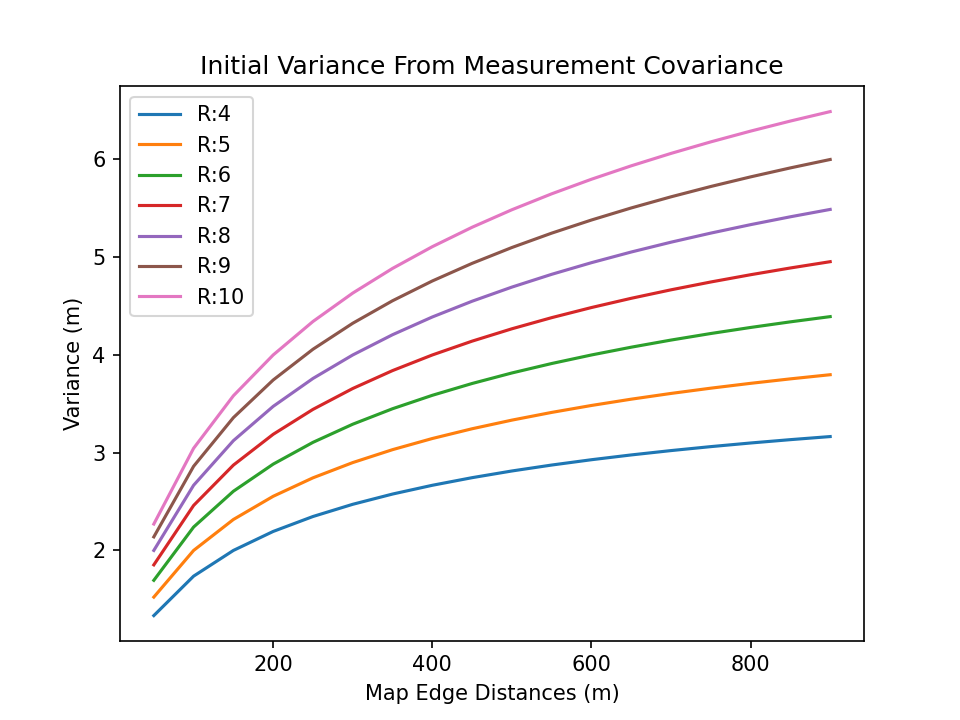

83.33333333333333 -15.277777777777786 100.32
4.166666666666666
166.66666666666666 74.99999999999999 100.32
8.333333333333332
250.0 165.27777777777777 100.32
12.5
333.3333333333333 255.55555555555554 100.32
16.666666666666664
416.6666666666667 345.8333333333333 100.32
20.833333333333336
500.0 436.1111111111111 100.32
25.0
583.3333333333334 526.3888888888889 100.32
29.166666666666668
666.6666666666666 616.6666666666666 100.32
33.33333333333333
750.0 706.9444444444445 100.32
37.5
833.3333333333334 797.2222222222222 100.32
41.66666666666667
916.6666666666666 887.4999999999999 100.32
45.83333333333333
1000.0 977.7777777777777 100.32
50.0
1083.3333333333333 1068.0555555555552 100.32
54.166666666666664
1166.6666666666667 1158.3333333333333 100.32
58.333333333333336
1250.0 1248.6111111111109 100.32
62.5
1333.3333333333333 1338.8888888888887 100.32
66.66666666666666
1416.6666666666667 1429.1666666666665 100.32
70.83333333333334
1500.0 1519.4444444444443 100.32
75.0
83.33333333333333 -15.2777777

In [7]:
##
dists = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
R_vals = [4,5,6,7,8,9,10]
plt.figure()
r_plots = {'dists':dists}
for jdx in range(len(R_vals)):
    R = R_vals[jdx]
    durations = []
    for idx in range(len(dists)):
        dur = getInitialVariance(2,3,dists[idx], Va, dt, sigma, R, 2, 1)
        durations.append(dur)
    plt.plot(dists, durations, label="R:{}".format(R))
    r_plots['r{}'.format(R)] = durations
plt.legend()
plt.xlabel("Map Edge Distances (m)")
plt.ylabel("Variance (m)")
plt.title("Initial Variance From Measurement Covariance")
savemat("rplots.mat", r_plots)

## Linear Growth

In [10]:
dist_e = 300
nodes = [(0.,0.), (dist_e,0.)]

edges = [(0, 1)]
dt =.1
N = 1000
v0 = 4.5
sigma = 4
T_end = 55
num_runs = 100
h, v, p = runIterations(nodes, edges, N, dt, T_end, num_runs, v0=v0,
                           sigma=sigma, e0=[(nodes[1], nodes[0])], x0=[.03], one_edge=True,
                           get_entropy=True, get_variance=True, get_prob=True, plot=False)
np.save("VarianceGrowthData", v)
np.save("ProbabilityGrowthData", p)
np.save("EntropyGrowthData", h)

/tmp/ipykernel_8848/1055900326.py:737: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for idx in tnrange(num_runs, leave=False):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_8848/1055900326.py:671: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(int(T_end/Ts), leave=False):


  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

In [11]:
##
v = np.load("VarianceGrowthData.npy")
# p = np.load("ProbabilityGrowthData.npy")
# h = np.load("EntropyGrowthData.npy")
predicted_v = [v[0] + idx*(dt*sigma)**2 for idx in range(v.shape[0])]
mu = 300
max_dist = 300
x = np.array([i for i in range(int(mu-max_dist),int(mu+max_dist),1)])

ent = []
predicted_ent = []
p_by_time = []
p_est_by_time = []
predicted_est_by_time = []
bias = 0
map_size = 600
mode_probability = [{1:1} for idx in range(v.shape[0])]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], map_size, dt, sigma, v.shape[0],
                                                                 mode_probability)
for idx in range(v.shape[0]):
    #calculate entropy and probability based on variance
    var = v[idx]
    est, entropy = getProbAndEntropy(var, x, mu, mode_probability[idx], 1)
#     print(entropy)
    p_est_by_time.append(est)
    ent.append(entropy)
entropy_from_sim_prob = []
for idx in range(p.shape[0]):
    entropy_from_sim_prob.append(getEntropy(p[idx], {1:1}))
    
p_est_by_time = np.array(p_est_by_time)
#rk4
# 0 order whole

/tmp/ipykernel_8848/1055900326.py:454: RuntimeWarning: divide by zero encountered in log
  if np.isfinite(np.log((1/num_modes)*probability[idx])) and probability[idx] > 0:


<IPython.core.display.Javascript object>


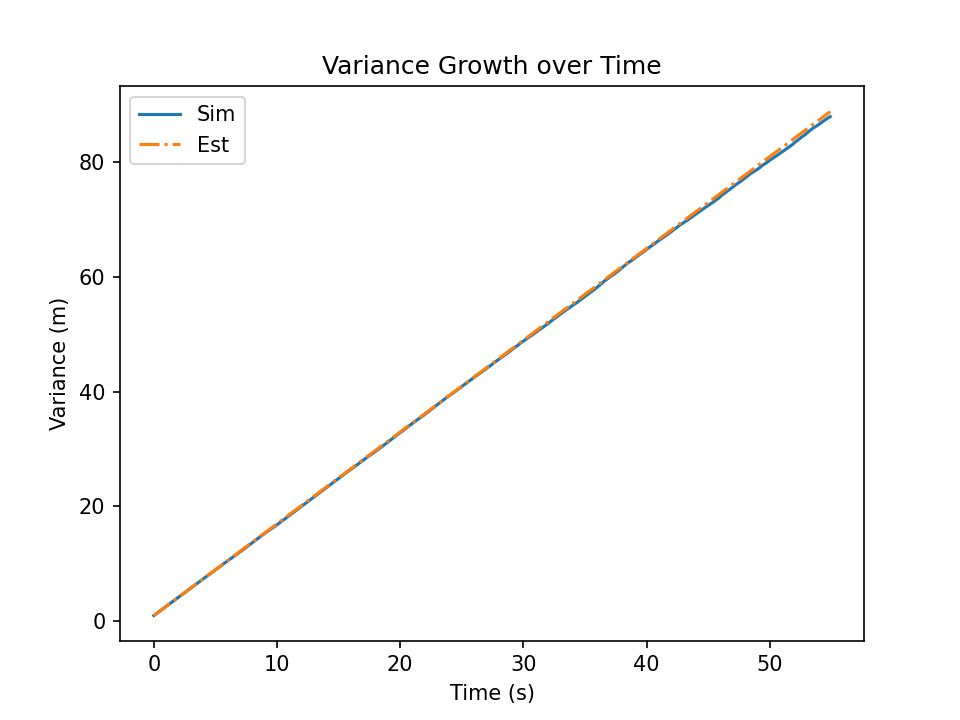

<IPython.core.display.Javascript object>


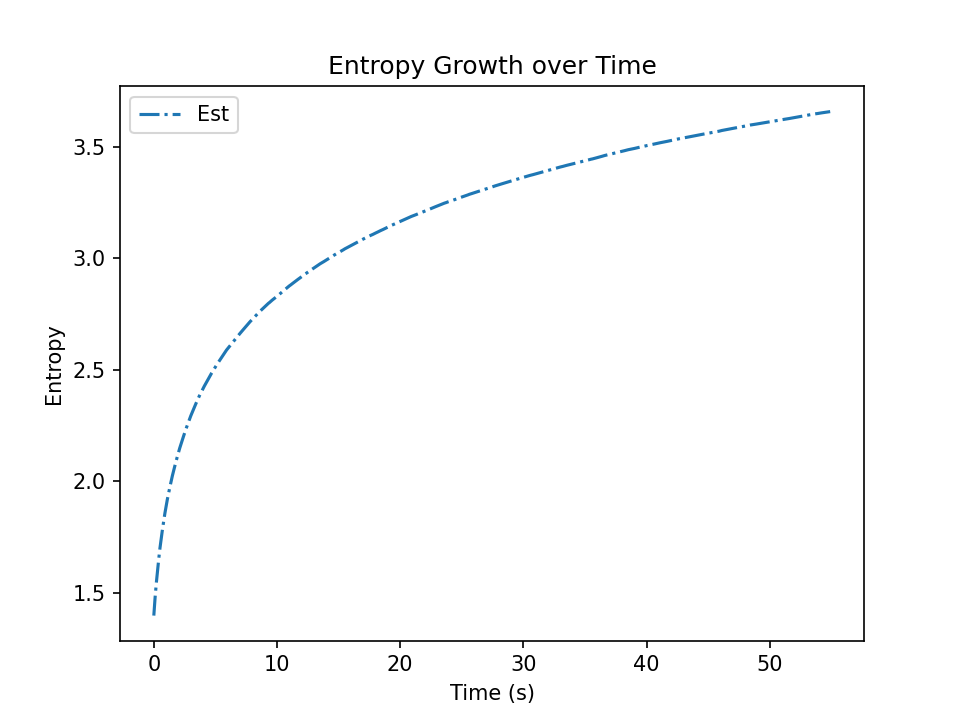

In [12]:
# print(predicted_v)
fig, ax = plt.subplots()
t = [dt*idx for idx in range(len(v))]
ax.set_title("Variance Growth over Time")
ax.plot(t,v, label='Sim')
ax.plot(t,predicted_v, '-.', label='Est')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Variance (m)")
ax.legend()
fig, ax = plt.subplots()
# ax.plot(t,h, label="Sim")
ax.plot(t,ent, '-.', label="Est")
# ax.plot(t, getProbAndEntropyOverTime(v[0], map_size, dt, sigma, num_steps, mode_probability, step_size=1, zero_out=False))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Entropy")
ax.legend()
ax.set_title("Entropy Growth over Time")
savemat('variance-growth.mat', {'t':t,'v':v,'pred_v':predicted_v})

In [97]:
# Va = 30
# dist_e = 350
# # intersections
# i = [(0.,0.), (dist_e,0.),
#      (0.,100), (dist_e,100)]
# edges = [(0, 1), 
#          (0, 2), 
#          (1, 3),
#          (2, 3)
#         ]

# # initialize the roadmap
# r = Roadmap(i, edges, rotate=False)

# sigma_vel = 10

# N = 1000
# dt = 0.3
# T_end = 200
# num_runs = 200

# P_fa = 0.0
# P_miss = 0.0
# R = 1*np.eye(2)
# H_sets = []
# V_sets =[]
# sigmas = []
# for jdx in tnrange(7, desc='sigmas'):
#     H = []
#     V = []
#     sigma_vel = (jdx+1)*2
#     sigmas.append(sigma_vel)
#     pf_args = {
#         'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':0, 
#         'sigma':sigma_vel, 'P_fa':P_fa, 'P_miss':P_miss}
#     for i in tnrange(num_runs, desc='runs', leave=False):
#         target1 = Particle(r, v0=0, dt=dt, e0=((0,0),(dist_e,0)), x0=.5, sigma=2)
#         target2 = Particle(r, v0=0, dt=dt, sigma=2)
#         targets = [target1]#, target2]
#         rbpf = RB_PF(r, 10, len(targets), pf_args)

#         Va = 30
#         agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)

#         H_current, variances = sim(r, rbpf, targets, agent, R, dt, T_end, plot=False)
#         H += [H_current]
#         V += [variances]
#     H_sets += [H]
#     V_sets += [V]

In [29]:
# N = 1000
# dt = 0.1
# T_end = 55
# num_runs = 20
# V_sets = []
# sigmas = []
# v0 = 4.5
# dists = [300, 600, 900, 1200, 1500, 2000, 3000]
# for jdx in tnrange(7, desc='sigmas'):
#     sigma = (jdx+1)*2
#     sigmas.append(sigma)
#     dist_e = dists[jdx]#300*(jdx+1)*2
#     nodes = [(0.,0.), (dist_e,0.)]
#     edges = [(0, 1)]
#     h, v, p = runIterations(nodes, edges, N, dt, T_end, num_runs, v0=v0,
#                                sigma=sigma, e0=[(nodes[1], nodes[0])], x0=[.03], one_edge=True,
#                                get_entropy=True, get_variance=True, get_prob=True)
#     V_sets.append(v)
# np.save("InitialVarianceSimulatorData", V_sets)

In [30]:
# fig, ax = plt.subplots()
# # sigmas_vel = [(jdx+1)*2 for jdx in range(3)]
# # print(V_sets[0])
# for i in range(5):#len(V_sets)):
#     v = V_sets[i]#np.mean(V_sets[i], axis=0)
#     t = np.array([x*dt for x in range(int(T_end/dt))])
#     ax.plot(t,v, label='{}'.format(sigmas[i]))
#     ax.plot(t,v[0]+t*dt*(sigmas[i])**2, label='{}-est'.format(sigmas[i]))
# # ax.plot(t,v)
# ax.legend()
# # for i in range(len(V_sets)):
# #     v = np.mean(V_sets[i], axis=0)
# #     print(v.shape)
# #     mean = [1000, 1500, 1750, 1875, 1937,1969]
# #     ranges = 10
# #     print([
# #         '{:.4f} {:.4f}'.format(np.min(v[mean[idx]-ranges:mean[idx]+ranges]), np.max(v[mean[idx]-ranges:mean[idx]+ranges]))
# #         for idx in range(len(mean))])

# Mode Splitting
A mode is a clump of particles in a particle filter that behave in similar fashions e.g. closely grouped particles moving in the same direction on a given edge of the map. In our scenario all modes are gaussian in nature and while modes can split apart we do not account for modes merging back together ever.

To determine the expected number of modes that exist at any point in time we need to do some map analysis to determine how the different map sections relate to each other. Once that is done we can identify how many modes are expected to exist after a period of time in which no detects have taken place. This formula assumes an initial certainty of knowledge regarding the target location and velocity.

## Map Analysis

In [13]:
##
def getAtomicPath(r, first, second):
    connections = list(r.graph[second].keys())
    connections.remove(first)
    if len(connections) != 1:
        return [first, second], r.graph[first][second], connections
    path, dist, num_exits = getAtomicPath(r, second, connections[0])
    path.insert(0, first)
    return path, dist + r.graph[first][second], num_exits
def getAtomicPaths(r, start):
    paths = []
    connections = list(r.graph[start].keys())
#     if len(connections) <= 2:
#         print("Not a starting point")
    if len(connections) > 2:
        for connection in connections:
            paths.append(getAtomicPath(r,start, connection))
    return paths
def getPathIndex(first, second, paths):
#     print(first, second)
#     print(paths)
    for idx in range(len(paths)):
        if [first, second] == paths[idx][:2]:
            return idx
    return -1
def isSame(option1, option2, paths, costs, exits):
    
    if costs[option1] != costs[option2]:
        return False
    # Find if all exits are to the same locations, and if the ones that go to
    ## different locations if their paths are the same
    different_exits = np.concatenate((exits[option1], exits[option2]))
    unique, counts = np.unique(different_exits, axis=0, return_counts=True)
    different_exits = unique[counts==1]
    for idx in range(len(different_exits)):
        path_end = paths[option1][-1] if tuple(different_exits[idx]) in exits[option1] else paths[option2][-1]
        print(option1, option2,different_exits[idx], getPathIndex(path_end, tuple(different_exits[idx]), paths))
    if len(different_exits) > 0:
        return False
    return True
    
def getCategories(paths, costs, exits):
    categories = [[(paths[0], costs[0], exits[0])]]
    for jdx in range(1,len(costs)):
        found = False
        for idx in range(len(categories)):
            if categories[idx][0][1] == costs[jdx]:
                if len(categories[idx][0][2]) == len(exits[jdx]):
                    found = True
                    categories[idx].append((paths[jdx], costs[jdx], exits[jdx]))
        if not found:
            categories.append([(paths[jdx], costs[jdx], exits[jdx])])
    return categories
def getStartingProbabilities(categories):
    local_dist = []
    for category in categories:
        local_dist.append(0)
        for entry in category:
            local_dist[-1] += entry[1]
    total_dist = np.sum(local_dist)
    probs = np.array(local_dist)/total_dist
    return probs
def getCategoryConnections(categories):
    starting = []
    for category in categories:
        starting.append([])
        for entry in category:
            starting[-1].append((entry[0][0], entry[0][1]))
            
    connections_raw = []
    for category in categories:
        connections_raw.append([])
        for entry in category:
            for exit in entry[2]:
                for idx in range(len(starting)):
                    if (entry[0][-1], exit) in starting[idx]:
                        connections_raw[-1].append(idx)
    
    connections = []
    for connection_raw in connections_raw:
        connection, counts = np.unique(connection_raw, return_counts=True)
        connections.append({})
        for idx in range(len(connection)):
            connections[-1][connection[idx]] = counts[idx]/np.sum(counts)
    return connections
def getCategoryNumExits(categories):
    category_exits = []
    for category in categories:
        exit_list = []
        for entry in category:
            exit_list.append(len(entry[2]))
#         print(exit_list)
        category_exits.append(np.mean(exit_list))
    return category_exits
def getCategoryDist(categories):
    dists = []
    for category in categories:
        dists.append(category[0][1])
    return dists
layout = (5,2)
dist = 100
V0 = 10
nodes, edges = createGridLayout(layout[0],layout[1],dist, dist)
r = Roadmap(nodes, edges, rotate=False)

# assume homogoneous until proof, then split
categories = [[]]
paths = []
costs = []
exits = []
for key in r.graph.keys():
    for path in getAtomicPaths(r,key):
        paths.append(path[0])
        costs.append(path[1])
        exits.append(path[2])
# print(isSame((paths[1], costs[1], exits[1]), (paths[2], costs[2], exits[2]), paths, costs, exits))
# print(isSame(1, 5, paths, costs, exits))
# print(len(paths))
categories = getCategories(paths,costs,exits)
for category in categories: print(category[0])
print('intial prob',getStartingProbabilities(categories))
print('prob to other categories',getCategoryConnections(categories))
print('num modes leaving category',getCategoryNumExits(categories))
print('distance to travel category',getCategoryDist(categories))

([(100.0, 0), (0, 0), (0, 100.0), (100.0, 100.0)], 300.0, [(200.0, 100.0), (100.0, 0)])
([(100.0, 0), (200.0, 0)], 100.0, [(300.0, 0), (200.0, 100.0)])
intial prob [0.46153846 0.53846154]
prob to other categories [{1: 1.0}, {0: 0.2857142857142857, 1: 0.7142857142857143}]
num modes leaving category [2.0, 2.0]
distance to travel category [300.0, 100.0]


## 2x3 and 3x3

```
4-------5-------6
|       |       |
|       |       |
|       |       |
1-------2-------3
```


```
7-------8-------9
|       |       |
|       |       |
|       |       |
4-------5-------6
|       |       |
|       |       |
|       |       |
1-------2-------3
```
### Without Merging
#### From Simulator

Running our simulator 10000 times and not allowing our modes to remerge we can get our truth value to compare with our formula for a 2x3 map

In [15]:
##
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData

dt = .1
duration = 60
num_runs = 10000
dists = [50, 100, 150, 200, 250, 300]
for idx in tnrange(len(dists)):
    dist_e = dists[idx]
    layout = (2,3)
    modes_over_time_2x3_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
#     np.save("data/ModesFromSimulation2x3-{}".format(dist_e), modes_over_time_2x3_raw)
#     modes_over_time_2x3_raw = np.load('data/ModesFromSimulation2x3-{}.npy'.format(dist_e)).item()
    modes_over_time_2x3 = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3[key] = key*modes_over_time_2x3_raw[key]
    
    layout = (3,3)
    modes_over_time_3x3_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
#     np.save("data/ModesFromSimulation3x3-{}".format(dist_e), modes_over_time_3x3_raw)
#     modes_over_time_2x3_raw = np.load('data/ModesFromSimulation3x3-{}.npy'.format(dist_e)).item()
    modes_over_time_2x3 = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3[key] = key*modes_over_time_2x3_raw[key]
#     fig, ax = plt.subplots(1,2)

#     plotModeData(ax[0], modes_over_time_2x3, dt, duration, label='2x3')
    # plotModeData(ax[1], modes_over_time_3x3, dt, 70, label='3x3')

/tmp/ipykernel_8848/1138848220.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for idx in tnrange(len(dists)):


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### From Formula

<IPython.core.display.Javascript object>


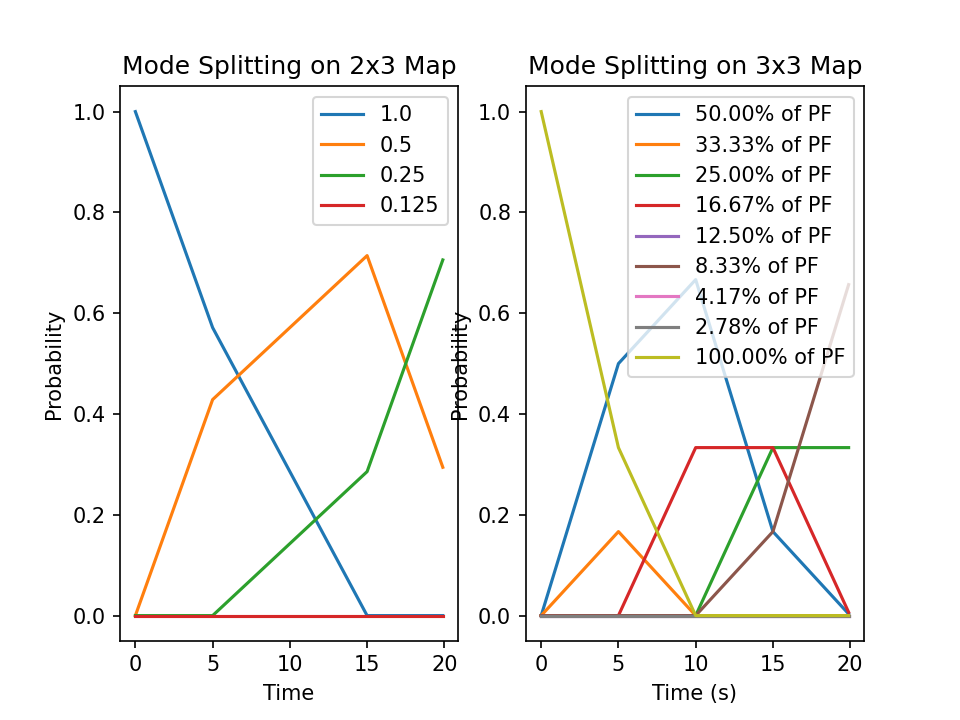

In [16]:
##
dist_e = 50
dt = .1
v0 = 10
edge_dur = dist_e/v0
duration = 20
map_dict2x3 = getMapDict2x3(dist_e, v0, old=False)
t, test_data, prob_data = getModeProbabilities(map_dict2x3, dt, duration)
# plt.figure()
fig, ax = plt.subplots(1,2)
ax[0].set_title("Mode Splitting on 2x3 Map")
for key in prob_data:
    ax[0].plot(t,prob_data[key], label=1/key)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Probability")
ax[0].legend()

map_dict3x3 = getMapDict3x3(dist_e,v0)
t, test_data, prob_data = getModeProbabilities(map_dict3x3, dt, duration)
# plt.figure()
ax[1].set_title("Mode Splitting on 3x3 Map")
for key in prob_data:
    ax[1].plot(t,prob_data[key], label="{:.2f}% of PF".format(100/key))
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Probability")
ax[1].legend()
data = {}
for key in prob_data:
    if max(prob_data[key]) > 0:
        data['a'+str(key)] = prob_data[key]
data['t'] = t
# savemat('probs.mat', data)

### With Merging - This section was never completed
#### From Simulator

<IPython.core.display.Javascript object>


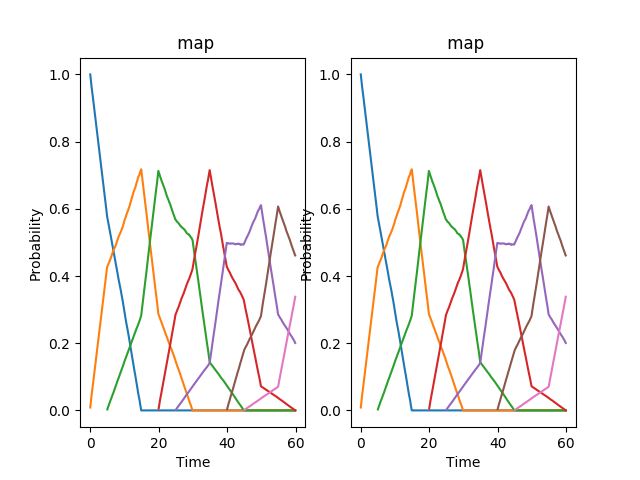

In [165]:
##
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData

dt = .1
duration = 60
num_runs = 10000
dists = [50, 100, 150, 200, 250, 300]
for idx in tnrange(len(dists)):

    layout = (2,3)
    modes_over_time_2x3_merged_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs, merging_allowed=True)
#     np.save("data/ModesFromSimulationMerged2x3-{}".format(dists[idx]), modes_over_time_2x3_raw)
#     modes_over_time_2x3_raw = np.load("data/ModesFromSimulationMerged2x3-{}.npy".format(dists[idx])).item()

    modes_over_time_2x3_merged = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3_merged[key] = key*modes_over_time_2x3_raw[key]

    layout = (3,3)
    modes_over_time_3x3_merged_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs, merging_allowed=True)
#     np.save("data/ModesFromSimulationMerged3x3-{}".format(dists[idx]), modes_over_time_2x3_raw)
#     modes_over_time_3x3_raw = np.load("data/ModesFromSimulationMerged3x3-{}.npy".format(dists[idx])).item()
    modes_over_time_3x3_merged = {}
    for key in modes_over_time_3x3_raw.keys():
        modes_over_time_3x3_merged[key] = key*modes_over_time_3x3_raw[key]
fig, ax = plt.subplots(1,2)
plotModeData(ax[0], modes_over_time_2x3_merged, dt, duration)
plotModeData(ax[1], modes_over_time_3x3_merged, dt, duration)

#### From Formula

<IPython.core.display.Javascript object>


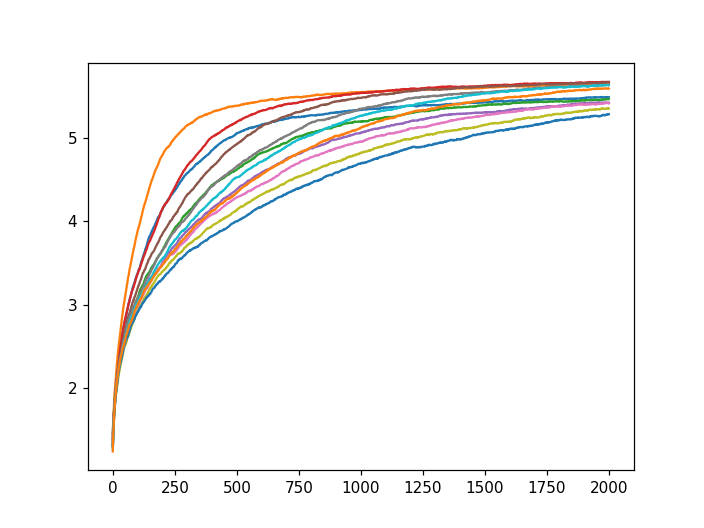

In [34]:
##
dists = [50,100,150,200,250,300]
plt.figure()
for dist in dists:
    ent = np.mean(np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dist)), axis=0)
#     print(ent.shape)
    plt.plot(ent)
    ent = np.mean(np.load("data/entropy_growth_3x3-{}-1_h_0.npy".format(dist)), axis=0)
#     print(ent.shape)
    plt.plot(ent)

# Entropy Growth Over Time

166.66666666666666 74.99999999999999 100.32
8.333333333333332
200.0 111.1111111111111 100.32
10.0
166.66666666666666 74.99999999999999 100.32
8.333333333333332


<IPython.core.display.Javascript object>


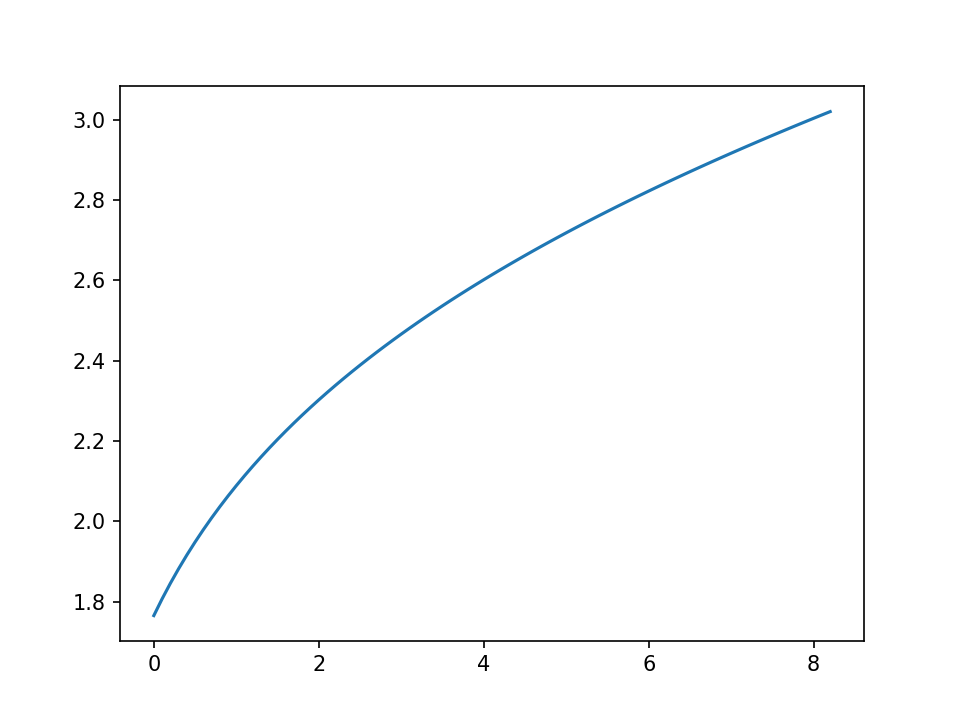

/tmp/ipykernel_8848/1055900326.py:454: RuntimeWarning: divide by zero encountered in log
  if np.isfinite(np.log((1/num_modes)*probability[idx])) and probability[idx] > 0:


83 83


FileNotFoundError: [Errno 2] No such file or directory: 'data/entropy_growth_2x3-100-1_h_0.npy'

In [17]:
##
dist = 100
dists = [100]
Va = 40
v0 = 10
dt = .1
sigma = 4
R = 5
num_edges = 7

probability_array = getProbabilityByDistsByTime([dist], dt, Va, v0, dur= 100)
probability_by_time = probability_array[0][0]
# data = np.load("data/ModesFromSimulation2x3-{}.npy".format(50))
# print(data.shape)
# data = np.load("data/data_2x3-{}-1_h_0.npy".format(dist))
# v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dist))
# plot_data = np.mean(data, axis=0)
# t = np.array([idx*dt for idx in range(plot_data.shape[0])])

# avg_min_variance, variance_mins = get_avg_min_variance(v_data, data)

# dur = len(probability_by_time)*dt

avg_min_variance = getInitialVariance(2,3,dist,Va,dt,sigma,R,2,1)

map_size = num_edges*dist
# predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
#                                                                  sigma, len(probability_by_time),
#                                                                  probability_by_time, 1, zero_out=True)
plt.figure()
# plt.plot(t,predicted_ent, label="zero'd")
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                 sigma, len(probability_by_time),
                                                                 probability_by_time, 1, zero_out=False)
# print(predicted_ent)
t = [dt*idx for idx in range(len(predicted_ent))]
print(len(t), len(predicted_ent))
plt.plot(t[:len(predicted_ent)],predicted_ent, label='raw')
for dist in dists:
    data = np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dist))
    data = np.mean(data, axis=0)
#     t = [idx*dt for idx in range(data.shape[0])]
    plt.plot(t, data[:len(t)], label='sim')
plt.legend()
# plt.plot(plot_data)

<IPython.core.display.Javascript object>


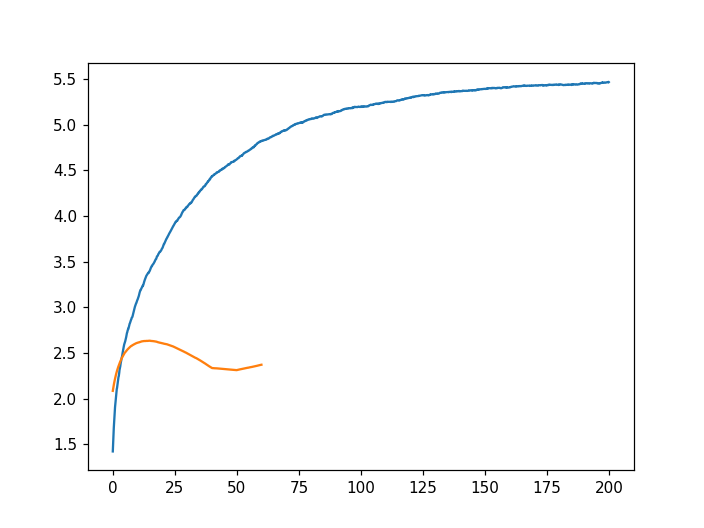

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:422: RuntimeWarning: divide by zero encountered in log


In [43]:
plt.figure()
dists = [100]
for idx in range(len(dists)):
    data = np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dists[idx]))
    data = np.mean(data, axis=0)
    plt.plot([dt*jdx for jdx in range(data.shape[0])],data, label='sim')
    
    modes_over_time_2x3_raw = np.load("data/ModesFromSimulation2x3-{}.npy".format(dists[idx])).item()
    modes_over_time_2x3_merged = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3_merged[key] = key*modes_over_time_2x3_raw[key]
    probability_by_time = []
    for idx in range(len(modes_over_time_2x3_merged[1])):
        probability_by_time.append({
            key: modes_over_time_2x3_merged[key][idx]
         for key in modes_over_time_2x3_merged.keys()})
#     print(probability_by_time)
#     print(modes_over_time_2x3_merged.keys())
        
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                     sigma, len(probability_by_time),
                                                                     probability_by_time, 1, zero_out=True)
    plt.plot([dt*jdx for jdx in range(len(predicted_ent))],predicted_ent, label='raw')
    

In [6]:
dists = [100]
dist=100
v0 = 10
R = 5
va = 40
sigma = 4
dt = .1
targets = 2
agents = 1
layout = (3,3)

probability_array = getProbabilityByDistsByTime(dists, dt, Va, v0)
probability_by_time = probability_array[0]
avg_min_variance = getInitialVariance(layout[0],layout[1],dist,Va,dt,sigma,R,targets,agents)
#     print(avg_min_variance)

num_edges = (layout[0]-1)*layout[1] + (layout[1]-1)*layout[0]
map_size = num_edges*dist
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                 sigma, len(probability_by_time),
                                                                 probability_by_time, 1)

138.88888888888889 44.907407407407405 100.32
6.944444444444445
177.77777777777777 87.03703703703702 100.32
8.88888888888889
177.77777777777777 87.03703703703702 100.32
8.88888888888889


AttributeError: 'list' object has no attribute 'keys'

# Entropy Lower Bound

## Multiple Modes

### Without Merging

In [20]:
## dists = [50, 100, 150, 200, 250,300]
dists = [100]
v0 = 10
R=5
Va = 40
sigma = 4
dt = .1
targets = 2
agents = 1
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF', '#FFFF99', '#99FFFF', '#99999F', '#9999F9', '#999F99']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF', '#FFFF55', '#55FFFF', '#55555F', '#5555F5', '#555F55']

ax, max_x, lower_bounds = plotSimEntropy(dists, colors)
print(lower_bounds)
# lower_bounds = lower_bounds[0]
lower_bounds_pred = []
min_var = []

probability_array = getProbabilityByDistsByTime(dists, dt, Va, v0)
# # for prob in probability_array[0]:
# #     print(len(prob))

# predicted_lower_bounds, avg_min_variances, entropy = getLowerBounds(dists, (2,3), dt, sigma, Va, R, targets, agents,
#                                                                          probability_array[0])
# print('lower bound', predicted_lower_bounds)
# lower_bounds_pred.append(predicted_lower_bounds)
# min_var.append(avg_min_variances)
# t = np.array([dt*idx for idx in range(max_x[0])])
# for idx in range(len(dists)):
#     ax[0].plot(t,[predicted_lower_bounds[idx] for jdx in range(max_x[0])], '--',
#                color=lower_bound_colors[idx], label='Est LB {}'.format(dists[idx]))
# ax[0].legend()

predicted_lower_bounds, avg_min_variances, entropy = getLowerBounds(dists, (3,3), dt, sigma, Va, R, targets, agents,
                                                                         probability_array[1])
lower_bounds_pred.append(predicted_lower_bounds)
min_var.append(avg_min_variances)
# print(lower_bounds, predicted_lower_bounds, avg_min_variances)
print('bounds', lower_bounds[1], predicted_lower_bounds)
# print(predicted_lower_bounds, avg_min_variances)
t = np.array([dt*idx for idx in range(max_x[1])])
for idx in range(len(dists)):
    ax[1].plot(t,[predicted_lower_bounds[idx] for jdx in range(max_x[1])], '--',
               color=lower_bound_colors[idx], label='Est LB {}'.format(dists[idx]))
    ax[1].plot(t, [lower_bounds[1][idx] for jdx in range(max_x[1])], 
               color=lower_bound_colors[idx], label='Est LB {}'.format(dists[idx]))
print('lower bound', predicted_lower_bounds)
ax[1].plot(t,[2.8194 for jdx in range(max_x[1])], 'r',
               color=lower_bound_colors[idx], label='Est LB {}'.format(dists[idx]))
# ax[1].legend()
# print(entropy)
# plt.figure()
# plt.plot([idx*dt for idx in range(len(entropy[0]))], entropy[0])
# savemat('entropy-growth', {'entropy':entropy[0]})

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_3x3-100-1_h_0.npy'

In [63]:
def getDuration(x,y, dist, Va, targets, agents):
    nodes, edges = createGridLayout(x,y,dist, dist)
    r = Roadmap(nodes, edges, rotate=False)
    edge_lengths = []
    for key in r.graph.keys():
        for key2 in r.graph[key].keys():
            edge_lengths.append(r.graph[key][key2])
    L_avg = 100.0#np.mean(edge_lengths)
    num_edges = 12

    avg_dist = getAvgDistance(r)
    dur = getRoundTripEst(targets, avg_dist)/Va
    print('avg', avg_dist)
    
    S_node = getAvgDistance(r)
    S_point = S_node*(1 + 1/num_edges) - L_avg*(1 + 2/(3*num_edges))
    print('Snode', S_node, 'Spoint', S_point,)
    dur = getRoundTripEst(targets, S_point)/Va
    return dur;


#     dur = getRoundTripEst(targets, S_node)/Va


# dists = [100]
# v0 = 10
# R=5
# Va = 40
# sigma = 4
# dt = .1
# targets = 2
# agents = 1
# probability_array = getProbabilityByDistsByTime(dists, dt, Va, v0)
# predicted_lower_bounds, avg_min_variances, entropy = getLowerBounds(dists, (3,3), dt, sigma, Va, R, targets,
#                                                                     agents, probability_array[1])

# # name = 'entropy_temp_orig2'
# # names = ['{}{}.npy'.format(name,label) for label in ('A','B','C','E','F','G')]#, 'entropy_temp_freq.npy',
# # # names.append('entropy_orig_all.npy')
# # data = np.load('entropy_orig_all.npy')
# # data = data[:247,:,:]
# # names = ['entropy_temp_with_neg.npy','entropy_temp_dist_20.npy']
# # print(names)
# colors = ['g','b','r','c']
# # plt.figure()
# # data = np.concatenate((data,np.concatenate([np.load(name) for name in names], axis=0)),axis=0)
# # data = np.unique(data, axis=0)
# # data = data[:60,:,:]
# # print(data.shape)
# # data_mean = np.mean(np.mean(data,axis=0),axis=1)
# bound = predicted_lower_bounds[0]
# # plt.plot(data_mean)
# # steady = np.mean(data_mean[250:])
# # plt.plot([0,2000], [steady,steady], '--k')
# # plt.plot([0,2000],[bound, bound],'k')
# # plt.legend()
# print('bound',predicted_lower_bounds[0])
# # np.save('entropy_orig4_all', data)
# # test = np.load('entropy_orig_all.npy')
# # print(test.shape)
# # print(steady)

In [13]:
# ideal_hnp.unique(data, axis=0).shape
print(a[:10])
print(data_mean[:10])

[6.6287492800282966, 6.6290465356077934, 6.629187854320049, 6.629193183313083, 6.629299125550952, 6.4166535643757445, 6.22537913663154, 6.253880005285458, 6.265226583643525, 6.272718635725383]
[6.62862761 6.62887095 6.62922213 6.62915358 6.62923278 6.62936547
 6.20394166 6.24681661 6.2609434  6.26950977]


### With Merging
simulator data will naturally used merging data for the entropy since it simply counts the number of particles in each bin of the map regardless of unmerged mode information

<IPython.core.display.Javascript object>


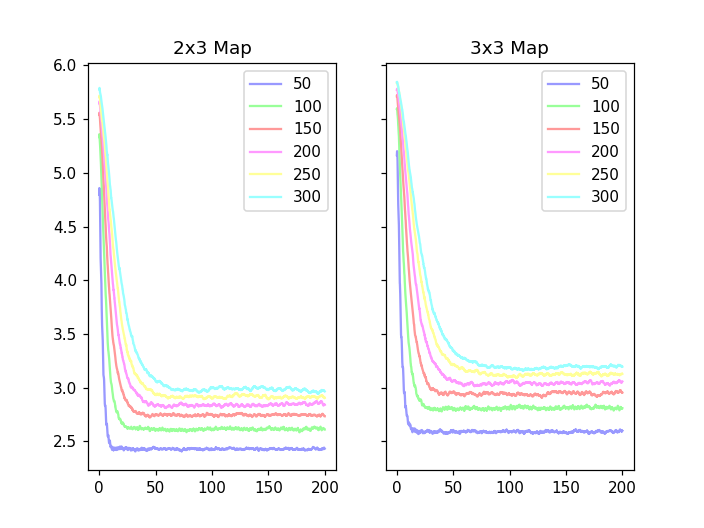

In [45]:
dists = [50, 100, 150, 200, 250,300]
v0 = 10
Va = 40
sigma = 4
dt = .1
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF', '#FFFF99', '#99FFFF', '#99999F', '#9999F9', '#999F99']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF', '#FFFF55', '#55FFFF', '#55555F', '#5555F5', '#555F55']

ax, max_x = plotSimEntropy(dists, colors)

## Get Supercomputer data

<IPython.core.display.Javascript object>


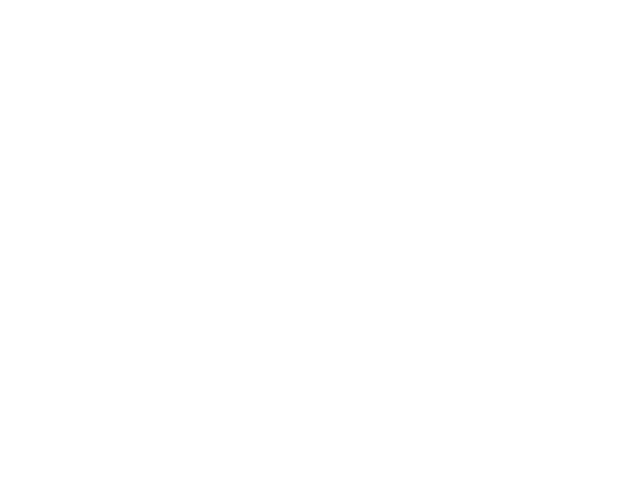

data/data_10x10-1-1_h_0.npy and data/data_10x10-1-1_h.npy do not exist
10 10 1 : (10, 1)


IndexError: tuple index out of range

In [19]:

getAllSuperComputerData([1])#,50, 100, 150, 200, 250,300])

In [ ]:
## Hardware Results from motion capture room

347.22222222222223 270.60185185185185 100.32
52.77777777777778
444.44444444444446 375.9259259259259 100.32
67.55555555555556
347.22222222222223 270.60185185185185 100.32
52.77777777777778


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:447: RuntimeWarning: divide by zero encountered in log


[5.527596650114098] [26.638652494477057]


<IPython.core.display.Javascript object>


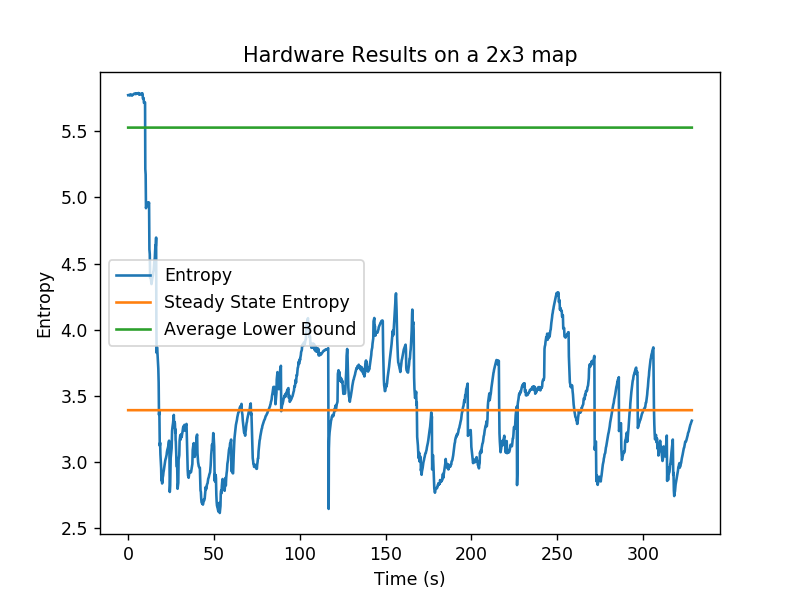

3.393037394425155


In [7]:
import rospy
ent = np.load('entropy.npy')
t = np.load('time.npy')
t = t - t[0]
max_idx = min(len(t), len(ent))

increase = 100
dists = [2.5*increase]
v0 = .24*increase
R=.3*increase
Va = (2.5/19)*increase
sigma = .2*increase
dt = .1
targets = 2
agents = 1
probability_array = getProbabilityByDistsByTime(dists, dt, Va, v0)

predicted_lower_bounds, avg_min_variances, entropy = getLowerBounds(dists, (2,3), dt, sigma, Va, R, targets, agents,
                                                                         probability_array[0])

print(predicted_lower_bounds, avg_min_variances)

plt.figure()
# plt.plot(t[:max_idx],ent[:max_idx], label="Entropy")
plt.plot(t[:max_idx], ent[:max_idx], label="Entropy")
bound = np.average(ent[100:])
print(bound)
plt.plot(t[:max_idx], [bound for e in ent], label="Steady State Entropy")
plt.plot(t[:max_idx], [predicted_lower_bounds[0] for e in ent], label="Average Lower Bound")
savemat('hw.mat', {'t':t[:max_idx],
                   'ent': ent[:max_idx],
                   'bound': [bound for e in ent[:max_idx]],
                   'predicted': [predicted_lower_bounds[0] for e in ent[:max_idx]]})
plt.ylabel("Entropy")
plt.xlabel("Time (s)")
plt.title("Hardware Results on a 2x3 map")
plt.legend()

In [2]:
# import rospy
ent = np.load('data_3x3-100-1_h.npy')
print(ent.shape)
# processed = []
# for idx in range(ent.shape[0]):
#     if ent[idx,200,0] < 4:
#         processed.append(ent)
# processed = np.array(processed)
# ent = processed
# ent = np.mean(np.mean(ent,axis=0),axis=1)
ent = ent[:,:,1]
    
# t = np.load('time.npy')
# t = t - t[0]
# max_idx = min(len(t), len(ent))
# print(max_idx)
plt.figure()
# plt.plot([.1*idx for idx in range(ent.shape[0])],ent)
plt.plot(ent)
# plt.plot(t[:max_idx],ent[:max_idx], label="Entropy")
# plt.plot(t[:max_idx], ent[:max_idx], label="Entropy")
bound = np.average(ent[100:])
# print(bound)
# plt.plot(t[:max_idx], [bound for e in ent], label="Steady State Entropy")
# plt.plot(t[:max_idx], [predicted_lower_bounds[0] for e in ent], label="Average Lower Bound")
# savemat('hw.mat', {'t':t[:max_idx],
#                    'ent': ent[:max_idx],
#                    'bound': [bound for e in ent[:max_idx]],
#                    'predicted': [predicted_lower_bounds[0] for e in ent[:max_idx]]})

# max_y = max(ent)+.2
# min_y = min(ent)
# plt.plot([0 for idx in range(int((max_y-min_y)/.1))], [idx*.1+min_y for idx in range(int((max_y-min_y)/.1))], '--')
# plt.plot([10 for idx in range(int((max_y-min_y)/.1))], [idx*.1+min_y for idx in range(int((max_y-min_y)/.1))], '--k')
# plt.plot([16 for idx in range(int((max_y-min_y)/.1))], [idx*.1+min_y for idx in range(int((max_y-min_y)/.1))], '--k')
# plt.ylabel("Entropy")
# plt.xlabel("Time (s)")
# plt.title("Hardware Results on a 2x3 map")
plt.legend()

NameError: name 'np' is not defined

(106, 2000, 2)
(242, 2000, 2)
(342, 2000, 2)
(236, 2000, 2)


<IPython.core.display.Javascript object>


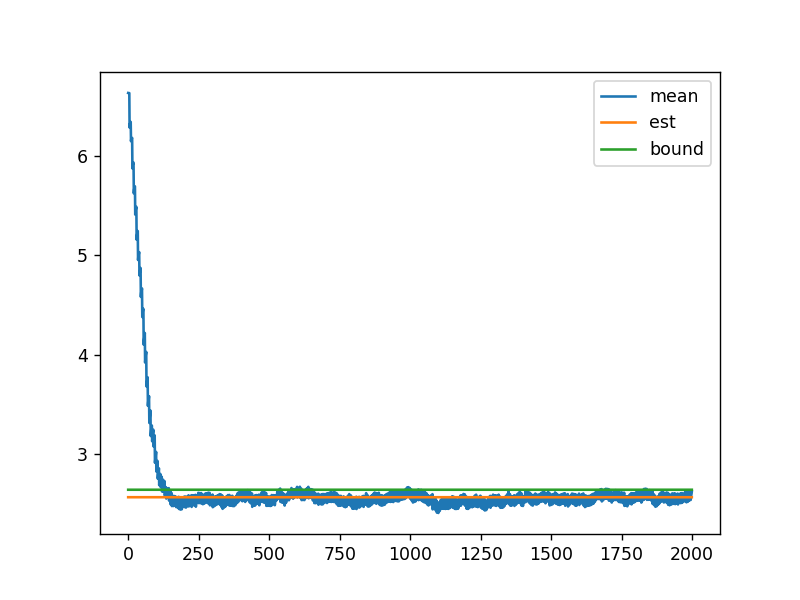

2.554853913654168


In [41]:
tmp = np.load('ideal.npy')
print(tmp.shape)
tmp = np.concatenate((tmp, np.load('ideal-0.npy')), axis=0)
print(tmp.shape)
tmp = np.concatenate((tmp, np.load('ideal_h.npy')), axis=0)
print(tmp.shape)
tmp = np.concatenate((tmp, np.load('temp/ideal_h.npy')), axis=0)
tmp = np.unique(tmp,axis=0)
np.save('ideal-0.npy', tmp)
print(tmp.shape)
plt.figure()
tmp = np.mean(np.mean(tmp,axis=0),axis=1)
plt.plot(tmp, label='mean')
print(np.mean(tmp[250:]))
plt.plot([np.mean(tmp[-50:]) for idx in range(tmp.shape[0])], label='est')
plt.plot([2.644528230141379 for idx in range(tmp.shape[0])], label='bound')
plt.legend()